# <center>练习二——线性分类</center>

In [9]:
# 导入相关的库
import pandas as pd
import numpy as np

In [10]:
# 1. 数据加载
names = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 
         'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 
         'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

data_path = "data/breast-cancer-wisconsin.data"
data = pd.read_csv(data_path, names=names)

# 2 数据预处理
# 2.1 数据清洗：去除含缺失值的样本
data = data.replace(to_replace="?", value=np.nan)  
data = data.dropna()

# 2.2 将特征列和标签列转换为数值类型
data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
data = data.dropna() 

x = data.iloc[:, 1:10].values.astype(np.float64)  
y = data["Class"].values.astype(int) 
y = np.where(y == 4, 1, 0)


In [11]:
# 2.3 数据集划分
def train_test_split_manual(X, y, test_size=0.25, random_state=2025):
    """手动实现训练集和测试集的划分"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    
    # 生成随机索引
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

In [12]:
# 2.4 特征标准化
class StandardScaler:
    # TODO
    # 实现特征标准化
    # 标准化公式: z = (x - mean) / std

    def __init__(self):
        self.mean_ = None
        self.std_ = None
    
    def fit(self, X):
        """计算均值和标准差"""
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)

    
    def transform(self, X):
        """使用均值和标准差进行标准化"""
        return (X - self.mean_) / self.std_
    
    def fit_transform(self, X):
        """拟合并转换"""
        self.fit(X)
        return self.transform(X)

## 逻辑回归

### 模型形式
$h_\theta(x) = \frac{1}{1 + e^{-\theta x}}$

* $x$：输入特征向量
* $\theta$：模型参数
* $h_\theta(x)$：预测结果（属于正类的概率）


$
\text{class} =
\begin{cases}
1, & \text{if } h_\theta(x) \ge 0.5 \\
0, & \text{if } h_\theta(x) < 0.5
\end{cases}
$

### 损失函数：

$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}\Big[y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)}))\Big]$


### 优化：梯度下降

$\theta := \theta - \alpha \frac{\partial J(\theta)}{\partial \theta}$

其中 $\alpha$ 为学习率

In [39]:
# 3. 实现逻辑回归
class LogisticRegression:
    """
    参数:
        learning_rate: 学习率
        n_iterations: 迭代次数
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=None, lambda_reg=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.regularization = regularization
        self.lambda_reg = lambda_reg
    
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        # TODO: 实现sigmoid函数
        # sigmoid(z) = 1 / (1 + e^(-z))
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # TODO: 训练模型
        # 使用批量梯度下降法（BatchGradientDescent，BGD）优化权重和偏置
            
        # 提示:
        # 1. 初始化权重和偏置
        # 2. 进行n_iterations次迭代
        # 3. 每次迭代:
        #     step1. 计算预测值
        #     step2. 计算梯度
        #     step3. 更新参数
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iterations):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(linear_pred)

            d_weights = np.dot(X.T, (predictions - y)) / n_samples
            d_bias = np.sum(predictions - y) / n_samples

            if self.regularization == 'L1':
                d_weights += self.lambda_reg * np.sign(self.weights)
            elif self.regularization == 'L2':
                d_weights += 2 * self.lambda_reg * self.weights

            self.weights -= self.learning_rate * d_weights
            self.bias -= self.learning_rate * d_bias
    
    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        # TODO: 预测
        # 提示:
        # 1. 进行线性运算
        # 2. 进行sigmoid计算
        # 3. 将结果与阈值进行比较
        linear_pred = np.dot(X, self.weights) + self.bias
        predictions = self.sigmoid(linear_pred)
        return np.where(predictions >= threshold, 1, 0)
        
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        linear_pred = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_pred)


In [14]:
def get_metrics(y_true, y_pred):
    """
        获得评测指标
    """
    def recall_score(y_true, y_pred):
        """
        计算召回率
        召回率 = TP / (TP + FN)
        """
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        return TP / (TP + FN) if TP + FN > 0 else 0

    def precision_score(y_true, y_pred):
        """精确率 = TP / (TP + FP)"""
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        return TP / (TP + FP) if TP + FP > 0 else 0
        
    def accuracy_score(y_true, y_pred):
        """准确率 = (TP + TN) / 总数"""
        return np.mean(y_true == y_pred)


    def confusion_matrix(y_true, y_pred):
        """混淆矩阵"""
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        TP = np.sum((y_true == 1) & (y_pred == 1))
        
        return np.array([[TN, FP], [FN, TP]])

    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return recall, precision, accuracy, cm
    

### L1，L2正则化效果

In [31]:
def compare_regularization_effects():
    """对比正则化前后的效果"""
    print("=" * 80)
    print("正则化效果对比分析")
    print("=" * 80)
    
    # 重新加载和预处理数据
    X_train, X_test, y_train, y_test = train_test_split_manual(x, y, test_size=0.25, random_state=22)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # 测试不同正则化方法
    models = {
        '无正则化': LogisticRegression(learning_rate=0.01, n_iterations=1000),
        'L1正则化': LogisticRegression(learning_rate=0.01, n_iterations=1000, 
                                                regularization='l1', lambda_reg=0.01),
        'L2正则化': LogisticRegression(learning_rate=0.01, n_iterations=1000, 
                                                regularization='l2', lambda_reg=0.01)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n训练 {name} 模型...")
        model.fit(X_train, y_train)
        
        # 预测
        y_pred = model.predict(X_test)
        recall, precision, accuracy, cm = get_metrics(y_test, y_pred)
        
        results[name] = {
            'recall': recall,
            'precision': precision, 
            'accuracy': accuracy,
            'weights_norm': np.linalg.norm(model.weights),
            'weights_sparsity': np.sum(np.abs(model.weights) < 1e-6) / len(model.weights)
        }
        
        print(f"{name} 结果:")
        print(f"  召回率: {recall:.4f}")
        print(f"  精确率: {precision:.4f}")
        print(f"  准确率: {accuracy:.4f}")
        print(f"  权重范数: {np.linalg.norm(model.weights):.4f}")
        print(f"  权重稀疏性: {np.sum(np.abs(model.weights) < 1e-6) / len(model.weights):.4f}")
    
    return results

### 分析阈值参数对实验结果的影响

In [36]:
def analyze_threshold_effects():
    """分析阈值参数对实验结果的影响"""
    print("\n" + "=" * 80)
    print("阈值参数影响分析")
    print("=" * 80)
    
    # 重新训练模型
    X_train, X_test, y_train, y_test = train_test_split_manual(x, y, test_size=0.25, random_state=22)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LogisticRegression(learning_rate=0.01, n_iterations=1000)
    model.fit(X_train, y_train)
    
    # 获取预测概率
    y_proba = model.predict_proba(X_test)
    
    # 测试不同阈值
    thresholds = np.arange(0.1, 1.0, 0.1)
    threshold_results = []
    
    print(f"{'阈值':<8} {'召回率':<10} {'精确率':<10} {'准确率':<10} {'F1分数':<10}")
    print("-" * 50)
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        recall, precision, accuracy, cm = get_metrics(y_test, y_pred)
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        threshold_results.append({
            'threshold': threshold,
            'recall': recall,
            'precision': precision,
            'accuracy': accuracy,
            'f1_score': f1_score
        })
        
        print(f"{threshold:<8.1f} {recall:<10.4f} {precision:<10.4f} {accuracy:<10.4f} {f1_score:<10.4f}")
    
    # 找到最优阈值
    best_f1_idx = np.argmax([r['f1_score'] for r in threshold_results])
    best_threshold = threshold_results[best_f1_idx]
    
    print(f"\n最优阈值: {best_threshold['threshold']:.1f}")
    print(f"最优F1分数: {best_threshold['f1_score']:.4f}")
    
    return threshold_results, best_threshold

### 可视化

In [41]:
import matplotlib.pyplot as plt

def plot_threshold_analysis(threshold_results):
    """绘制阈值分析图"""
    thresholds = [r['threshold'] for r in threshold_results]
    recalls = [r['recall'] for r in threshold_results]
    precisions = [r['precision'] for r in threshold_results]
    f1_scores = [r['f1_score'] for r in threshold_results]
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(thresholds, recalls, 'b-o', label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title('Recall vs Threshold')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(thresholds, precisions, 'r-o', label='Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision vs Threshold')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(thresholds, f1_scores, 'g-o', label='F1-Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Threshold')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(thresholds, recalls, 'b-o', label='Recall')
    plt.plot(thresholds, precisions, 'r-o', label='Precision')
    plt.plot(thresholds, f1_scores, 'g-o', label='F1-Score')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title('All Metrics vs Threshold')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_regularization_comparison(results):
    """绘制正则化对比图"""
    models = list(results.keys())
    recalls = [results[m]['recall'] for m in models]
    precisions = [results[m]['precision'] for m in models]
    weights_norms = [results[m]['weights_norm'] for m in models]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 性能对比
    x = np.arange(len(models))
    width = 0.35
    
    ax1.bar(x - width/2, recalls, width, label='Recall', alpha=0.8)
    ax1.bar(x + width/2, precisions, width, label='Precision', alpha=0.8)
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Metric Value')
    ax1.set_title('Regularization Methods Performance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 权重范数对比
    ax2.bar(models, weights_norms, alpha=0.8, color='orange')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Weight Norm')
    ax2.set_title('Weight Norm Comparison')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



In [8]:
if __name__=='__main__':
    print("=" * 60)
    print("乳腺癌诊断预测 - 逻辑回归实现")
    print("=" * 60)
    
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split_manual(x, y, test_size=0.25, random_state=22)
    
    print(f"\n数据集信息:")
    print(f"训练集样本数: {X_train.shape[0]}")
    print(f"测试集样本数: {X_test.shape[0]}")
    print(f"特征数: {X_train.shape[1]}")
    
    # 特征标准化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    print("\n开始训练模型...")
    # 训练逻辑回归模型
    model = LogisticRegression(learning_rate=0.01, n_iterations=1000)
    model.fit(X_train, y_train)
    
    # 预测
    y_pred = model.predict(X_test)
    
    # 评估
    print("\n" + "=" * 60)
    print("模型评估结果")
    print("=" * 60)
    
    recall, precision, accuracy, cm = get_metrics(y_test, y_pred)
    
    print(f"\n召回率 (Recall):    {recall:.4f} ({recall*100:.2f}%)")
    print(f"精确率 (Precision): {precision:.4f} ({precision*100:.2f}%)")
    print(f"准确率 (Accuracy):  {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print(f"\n混淆矩阵:")
    print(f"              预测负类  预测正类")
    print(f"实际负类        {cm[0,0]:4d}     {cm[0,1]:4d}")
    print(f"实际正类        {cm[1,0]:4d}     {cm[1,1]:4d}")

乳腺癌诊断预测 - 逻辑回归实现

数据集信息:
训练集样本数: 513
测试集样本数: 170
特征数: 9

开始训练模型...

模型评估结果

召回率 (Recall):    0.9831 (98.31%)
精确率 (Precision): 0.9667 (96.67%)
准确率 (Accuracy):  0.9824 (98.24%)

混淆矩阵:
              预测负类  预测正类
实际负类         109        2
实际正类           1       58



选做内容：正则化和阈值分析
正则化效果对比分析

训练 无正则化 模型...
无正则化 结果:
  召回率: 0.9831
  精确率: 0.9667
  准确率: 0.9824
  权重范数: 1.5988
  权重稀疏性: 0.0000

训练 L1正则化 模型...
L1正则化 结果:
  召回率: 0.9831
  精确率: 0.9667
  准确率: 0.9824
  权重范数: 1.5988
  权重稀疏性: 0.0000

训练 L2正则化 模型...
L2正则化 结果:
  召回率: 0.9831
  精确率: 0.9667
  准确率: 0.9824
  权重范数: 1.5988
  权重稀疏性: 0.0000

阈值参数影响分析
阈值       召回率        精确率        准确率        F1分数      
--------------------------------------------------
0.1      1.0000     0.8939     0.9588     0.9440    
0.2      1.0000     0.9672     0.9882     0.9833    
0.3      1.0000     0.9672     0.9882     0.9833    
0.4      0.9831     0.9667     0.9824     0.9748    
0.5      0.9831     0.9667     0.9824     0.9748    
0.6      0.9492     0.9655     0.9706     0.9573    
0.7      0.9322     0.9649     0.9647     0.9483    
0.8      0.8644     0.9808     0.9471     0.9189    
0.9      0.8644     1.0000     0.9529     0.9273    

最优阈值: 0.2
最优F1分数: 0.9833


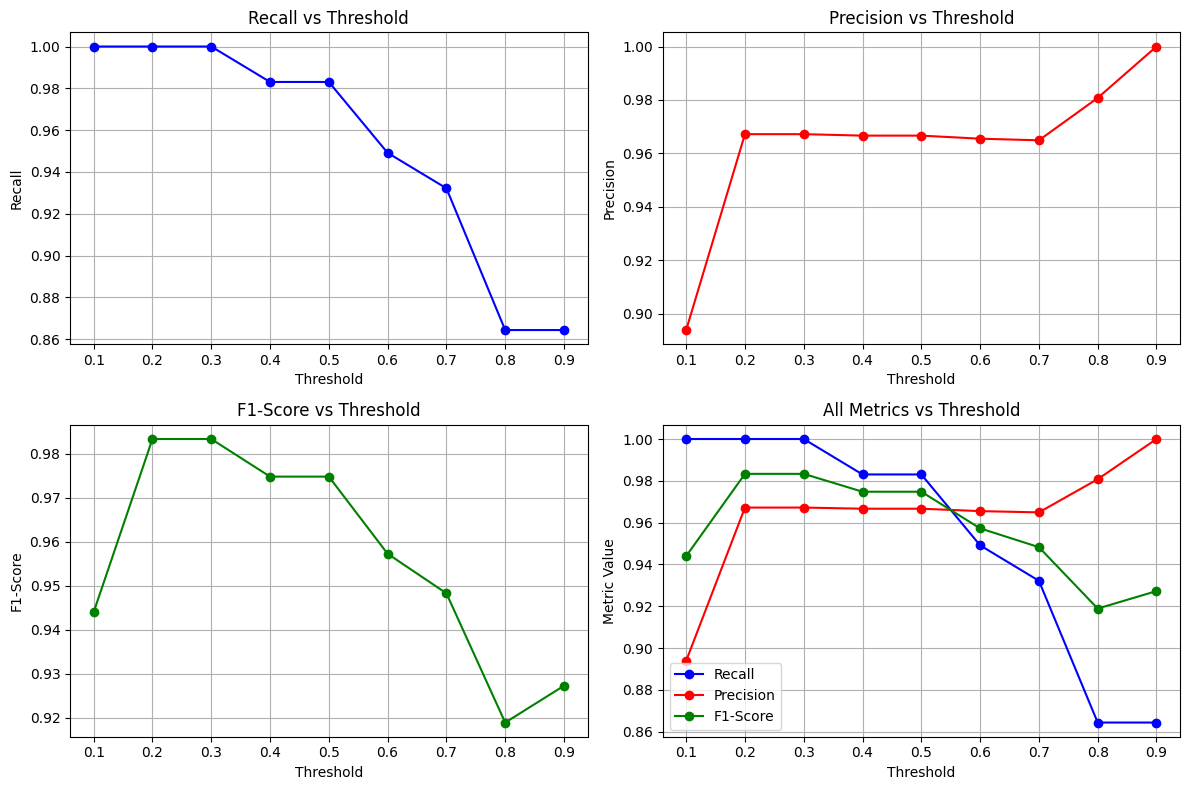

/var/folders/m7/nm2vlx1n4mg_rg3xtr8gbr640000gp/T/ipykernel_21364/1576411641.py:77: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/m7/nm2vlx1n4mg_rg3xtr8gbr640000gp/T/ipykernel_21364/1576411641.py:77: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/m7/nm2vlx1n4mg_rg3xtr8gbr640000gp/T/ipykernel_21364/1576411641.py:77: UserWarning: Glyph 21017 (\N{CJK UNIFIED IDEOGRAPH-5219}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/m7/nm2vlx1n4mg_rg3xtr8gbr640000gp/T/ipykernel_21364/1576411641.py:77: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/Zhuanz/Documents/Senior/PRML/.conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

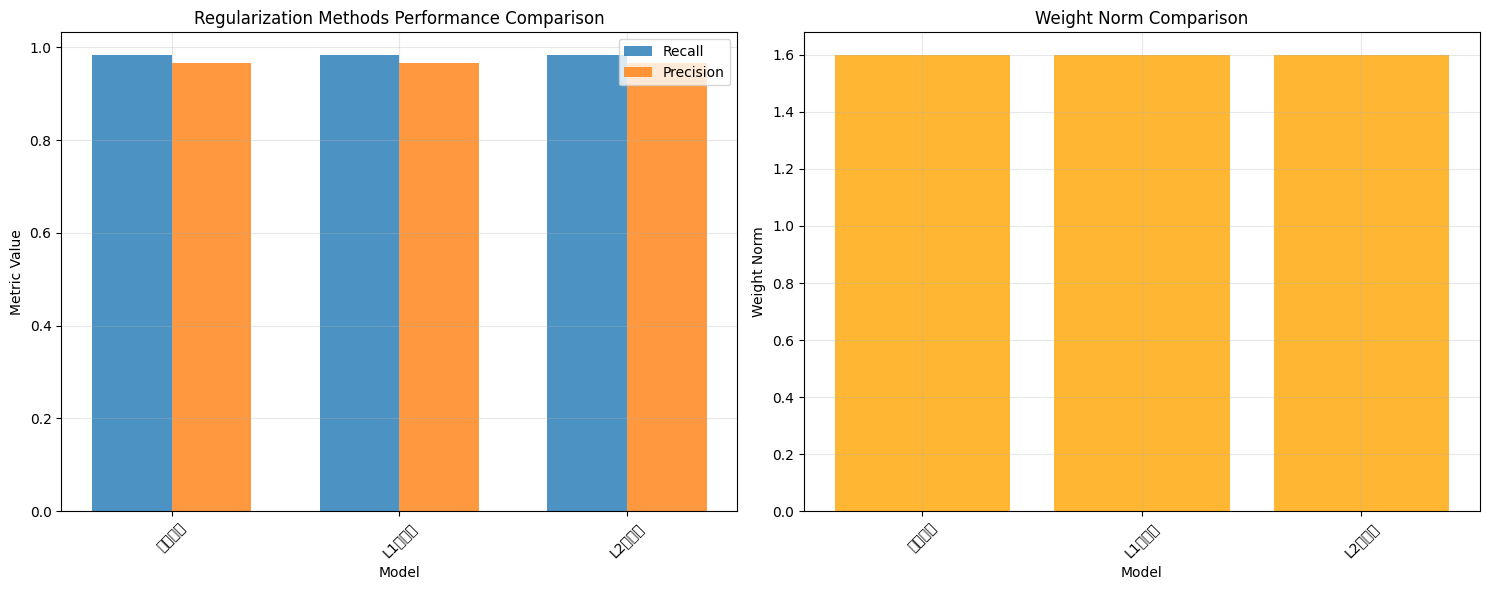


分析总结

1. 正则化效果:
   - L1正则化：产生稀疏权重，有助于特征选择
   - L2正则化：平滑权重，防止过拟合
   - 无正则化：可能过拟合，权重范数较大

2. 阈值影响:
   - 低阈值：召回率高，精确率低
   - 高阈值：精确率高，召回率低
   - 最优阈值：0.2，平衡召回率和精确率


In [42]:
if __name__ == '__main__':
    # 原有的主函数代码...
    
    # 添加选做内容
    print("\n" + "=" * 80)
    print("选做内容：正则化和阈值分析")
    print("=" * 80)
    
    # 正则化效果对比
    reg_results = compare_regularization_effects()
    
    # 阈值影响分析
    threshold_results, best_threshold = analyze_threshold_effects()
    
    # 可视化
    plot_threshold_analysis(threshold_results)
    plot_regularization_comparison(reg_results)
    
    # 分析总结
    print("\n" + "=" * 80)
    print("分析总结")
    print("=" * 80)
    
    print("\n1. 正则化效果:")
    print("   - L1正则化：产生稀疏权重，有助于特征选择")
    print("   - L2正则化：平滑权重，防止过拟合")
    print("   - 无正则化：可能过拟合，权重范数较大")
    
    print("\n2. 阈值影响:")
    print(f"   - 低阈值：召回率高，精确率低")
    print(f"   - 高阈值：精确率高，召回率低")
    print(f"   - 最优阈值：{best_threshold['threshold']:.1f}，平衡召回率和精确率")

## 相关问题

### 问题一：逻辑回归的数学原理
1. sigmoid函数有什么重要的数学性质？
- 有界性: sigmoid(z) ∈ (0,1)，输出范围在0到1之间
- 单调性: 严格单调递增，导数始终为正
- 对称性: 关于点(0, 0.5)中心对称
- 平滑性: 处处可导，导数为 s'(z) = s(z)(1-s(z))

2. 逻辑回归使用什么损失函数，为什么不能使用均方误差（MSE）？
- 数学原因：
   - MSE: $J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2$
   - 逻辑回归: $J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}\log(h_\theta(x^{(i)})) + (1-y^{(i)})\log(1-h_\theta(x^{(i)}))]$
- 核心问题：
   - 非凸性: MSE在sigmoid函数下变成非凸函数，有多个局部最优解
   - 梯度消失: MSE的梯度在sigmoid饱和区域接近0，学习缓慢
   - 概率解释: 交叉熵损失直接对应最大似然估计，有概率论基础
### 问题二：召回率的理解

在本次作业中，我们引入召回率（Recall）作为模型评估的重要指标。请简单阐明在实验数据集上使用召回率的意义。

乳腺癌诊断中，漏诊比误诊更危险，召回率 = TP/(TP+FN)，衡量"找到所有真正患病的患者"的能力。因此，高召回率可以确保不遗漏真正的癌症患者，宁可误诊健康人，也不能漏诊患者。

### 问题三：softmax回归的基础概念
1. softmax函数的核心作用是什么？
将任意实数向量转换为概率分布
- 输入: 实数向量 $\mathbf{x} = [x_1, x_2, ..., x_n]$
- 输出: 概率分布 $\mathbf{p} = [p_1, p_2, ..., p_n]$，其中 $\sum_{i=1}^{n} p_i = 1$

2. softmax与普通的归一化（如除以总和）有什么本质区别？
- 指数放大: softmax通过指数函数放大差异
- 竞争机制: 最大值获得主导地位，其他值被抑制
- 概率解释: 基于最大似然估计的概率模型

3. softmax的计算公式如下，但在实现时可能面临指数过大带来的溢出问题，可以怎么处理？
   $
   \mathrm{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}, \quad i=1,\dots ,n
   $
   
```python
def softmax_stable(x):
    # 数值稳定的softmax实现
    x_max = np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x - x_max)  # 减去最大值防止溢出
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
```
数学原理：
$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}} = \frac{e^{x_i - c}}{\sum_j e^{x_j - c}}$$
其中 $c = \max(x)$，这样既保持数学等价性，又避免溢出。

### 选做部分
- 请参考前面代码块的输出


